Summary of magicblast


In [103]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
import warnings
warnings.filterwarnings('ignore')

In [147]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [29]:
PROJECT_CODE='PRJNA573298'
BASE_PATH = f'/mnt/1TB_0/Data/Assembly/{PROJECT_CODE}/'

#SRA='SRR11092060'
#path=f'/mnt/1TB_0/Data/Assembly/{PRJ}/{SRA}/magic_blast/'
#dbname='gsa_bsl_nt_db'
dbname='nt'
kmer='k141'


#magicblast on contigs
magic_blast_sam_tail=f'_{dbname}_final_contigs_magicBLAST.sam'
f_contigs_file_tail=f'_{dbname}_magic_blast_asc_contigs.txt'

In [30]:
def read_gi_accession_title(gi_asc_file):
    gis=[]
    accessions=[]
    titles=[]
    with open(gi_asc_file, 'r') as infile:
        data = infile.readlines()
        for i in data:
            output=i.split(' ',2)
            gis.append(output[0])
            accessions.append(output[1])
            titles.append(output[2])
    return gis, accessions, titles
    

In [31]:
def get_accession(s):
    accession = None
    row= None
    chunks = s.split("\t")
    if len(chunks)>2:
        try:
            int(chunks[2])
        except:
            accession = chunks[2]
            row = s
    return accession, row

In [32]:
def write_contigs(sra, magic_blast_sam_tail, f_contigs_file_tail):
    path = BASE_PATH+sra+'/magic_blast/'
    f_contigs= open(path+sra+f_contigs_file_tail, 'w')
    accessions = []
    fpath=path+sra+magic_blast_sam_tail
    print(f'input: {fpath}, saving contigs: {f_contigs}')
    with open(fpath) as f:   
        for line in f:
            if line.startswith(kmer) or line.startswith('>'+kmer):
                accession, row=get_accession(line)
                if row is not None:
                    accessions.append(accession)
                    f_contigs.write(f'{row}')
        print(f'number accession identified in sam file: {len(accessions)}')
    return accessions

In [33]:
def get_accession_dat(values, dbname='nt'):
    vdats=[]
    #print(f'dbname: {dbname}, accessions: {len(values)}')
    for v in values:
        if v.strip() in ACCESSIONS:
            idx=ACCESSIONS.index(v)
            vdats.append(v+' '+TITLES[idx].replace('\n',''))
        elif v.strip() in GIS:
            idx=GIS.index(v)
            vdats.append(ACCESSIONS[idx]+' '+TITLES[idx].replace('\n',''))
        else:
            print(f'{v} not found')
            try:
                vdat=!blastdbcmd -db $dbname -entry $v
                vdats.append(vdat[0].split(',')[0])
            except Exception as e:
                print(e)
                vdats.append(v)
    return vdats

In [34]:
#vdat=!blastdbcmd -db $dbname -entry KY063616.1
#vdat[0]

In [35]:
dbname

'nt'

In [36]:
#all_accessions=!blastdbcmd -db $dbname -entry all

In [37]:
#accession_titles=[a for a in all_accessions if a.startswith('>')]

In [38]:
#with open("gsa_bsl_nt_db_titles.txt", 'w') as f:
#    f.write('\n'.join(accession_titles))

In [39]:
def workflow(sra, dbname):
    try:
        accessions = write_contigs(sra, magic_blast_sam_tail, f_contigs_file_tail)
        values, counts = np.unique(accessions, return_counts=True)
        #print(f'{len(values)}, {accessions[0]}, {values[0]}')
        vdats=get_accession_dat(values, dbname)
        return vdats, counts
    except FileNotFoundError as e:
        return None, None

### All SRA's

In [40]:
sra_list=['SRR10168373','SRR10168374','SRR10168375', 'SRR10168376','SRR10168377', 'SRR10168378',\
      'SRR10168379','SRR10168380','SRR10168381','SRR10168382','SRR10168383','SRR10168384',\
     'SRR10168385','SRR10168386','SRR10168387','SRR10168388','SRR10168389','SRR10168390',\
     'SRR10168391','SRR10168392','SRR10168393']

In [41]:
def write_summary(sra, dvdat):
    path = BASE_PATH+sra+'/magic_blast/'
    print(f'sra {sra}')
    #print(f'keys {dvdat.keys()}')
    #print(f'values {dvdat.values()}')
    print('\n')
    for d, v in dvdat.items():
        if sra==d:
            with open(path+f'{d}_{dbname}_{kmer}_magicBLAST_summary.txt', 'w') as f:
                f.write(f'SRA: {d}, database: {dbname}\n')
                for i, s in enumerate(v[0]):
                    if (s.find('command not found')==-1):
                        f.write(f'{s}, count: {v[1][i]}\n')


In [42]:
def process_summary():
    GIS,ACCESSIONS,TITLES=read_gi_accession_title('/mnt/1TB_ssd/Data/BLAST/nt.gi_taxid.tsv')
    dvdat={}
    for sra in sra_list:
        vdats, counts= workflow(sra, dbname)
        if vdats is not None:
            dvdat[sra]=(vdats, counts)
            write_summary(sra, dvdat)
    

In [43]:
#process_summary()

### Sats

In [44]:
def get_asc_descr_count(sra): 
    accessions=[]
    descriptions=[]
    counts=[]
    path = BASE_PATH+sra+'/magic_blast/'
    with open(path+f'{sra}_{dbname}_{kmer}_magicBLAST_summary.txt', 'r') as f:
        lines = [line.rstrip('\n') for line in f]
        total=len(lines)-1
        for line in lines:
            if not 'database:' in line: #ignore header
                asc=line.split(None, 1)[0]
                title=line.split(None, 1)[1].split(', count:')[0]
                count=line.split(None, 1)[1].split(', count:')[1]
                accessions.append(asc)
                descriptions.append(title)
                counts.append(count)
    return accessions, descriptions, counts, total


In [45]:
def get_indexes(substr, str_list):
    index_list = []
    i = 0
    for e in str_list:
        if substr in e.lower():
            index_list.append(i)
        i +=1
    return index_list

In [46]:
def get_descr(sra):
    accessions, descriptions, counts, total=get_asc_descr_count(sra)
    human = [s for s in descriptions if 'human' in s.lower()]
    homo_sapiens = [s for s in descriptions if 'homo sapiens' in s.lower()]
    h_sapiens = [s for s in descriptions if 'h.sapiens' in s.lower()]
    human_contigs = human+homo_sapiens+h_sapiens
    pangolin = [s for s in descriptions if 'manis javanica' in s.lower()]
    pangolin_p = [s for s in descriptions if 'manis pentadactyla' in s.lower()]
    pangolin=pangolin+pangolin_p
    mouse = [s for s in descriptions if 'mus musculus' in s.lower()]
    vector= [s for s in descriptions if 'vector' in s.lower()]
    pig = [s for s in descriptions if 'sus scrofa' in s.lower()]
    cat = [s for s in descriptions if 'felis catus' in s.lower()]
    tiger = [s for s in descriptions if 'panthera tigris' in s.lower()]
    dog = [s for s in descriptions if 'canis lupus' in s.lower()]
    virus = [s for s in descriptions if 'virus' in s.lower()]
    pipistrellus = [s for s in descriptions if 'pipistrellus' in s.lower()]
    rhinolophus = [s for s in descriptions if 'rhinolophus' in s.lower()]
    bat = pipistrellus + rhinolophus
    lst = ['human', 'pangolin', 'mouse', 
            'pig', 'cat', 'tiger', 'dog', 'bat', 'virus', 'vector']
    lengths = [len(human_contigs), len(pangolin), len(mouse),  
            len(pig), len(cat), len(tiger), len(dog), len(bat), len(virus), len(vector)]
    final_contigs=BASE_PATH+sra+'/megahit_default/final.contigs.fa'
    with open(final_contigs) as final_contigs_file:
        total_contigs=sum(1 for _ in final_contigs_file)
    res = [int(i) for i in counts]
    total_contigs_matched=sum(res)
    sra_l=[sra]*len(lst)
    fractions_matched = [len(human_contigs)/total_contigs_matched, len(pangolin)/total_contigs_matched, len(mouse)/total_contigs_matched,  
            len(pig)/total_contigs_matched, len(cat)/total_contigs_matched, len(tiger)/total_contigs_matched, len(dog)/total_contigs_matched, len(bat)/total_contigs_matched, len(virus)/total_contigs_matched, len(vector)/total_contigs_matched]
    df = pd.DataFrame(list(zip(sra_l, lst, lengths, fractions_matched)),
               columns =['SRA','Name', 'count', 'fraction_matched'])
    return df

In [51]:
sns.set(rc={"figure.figsize":(4, 4)})
def plot_df(df, sra):
    ax=df.plot(x='Name', y='count', kind='bar')
    ax.set_title(sra, fontsize=12)
    fig = plt.gcf()
    fig.savefig(BASE_PATH+sra+'/magic_blast/'+f'{sra}_{dbname}_{kmer}_magicBLAST_species.png', bbox_inches="tight")

/home/walle/miniconda3/envs/blastasm/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


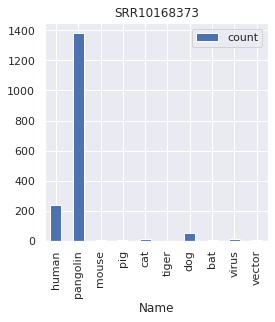

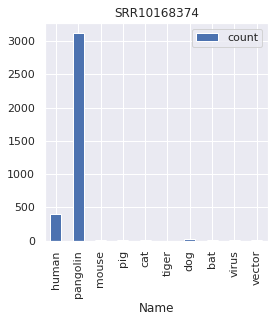

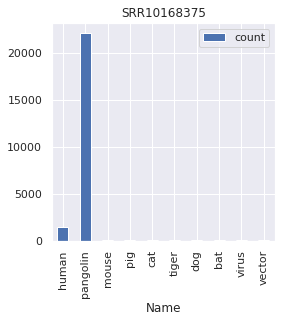

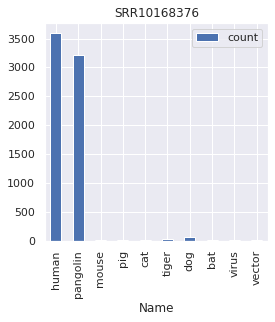

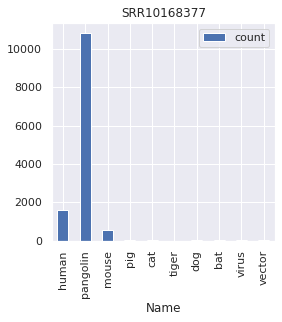

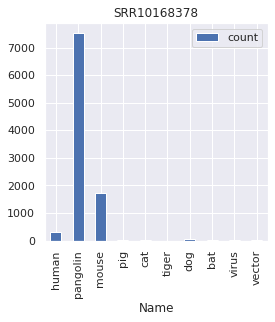

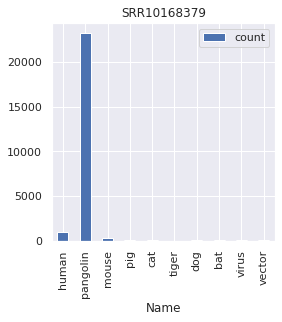

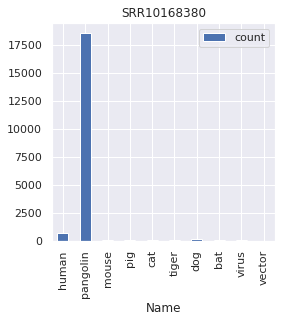

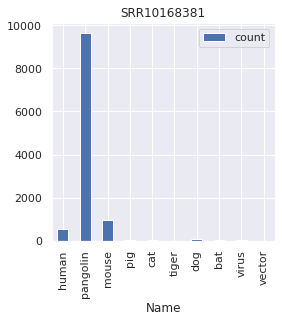

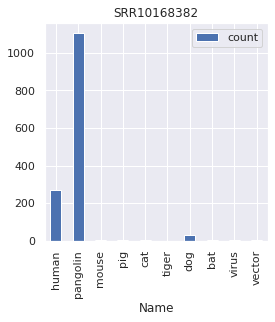

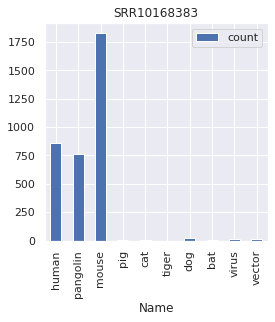

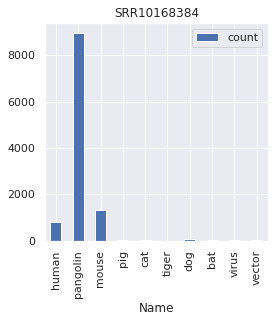

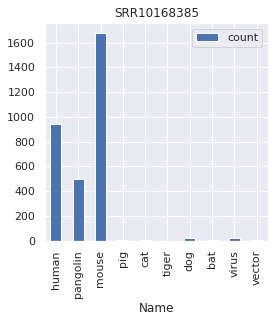

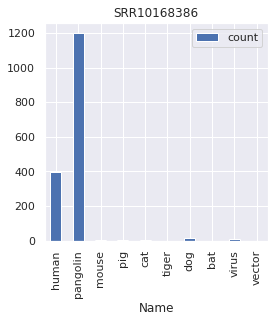

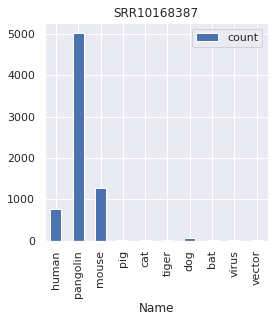

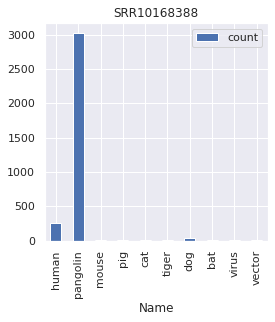

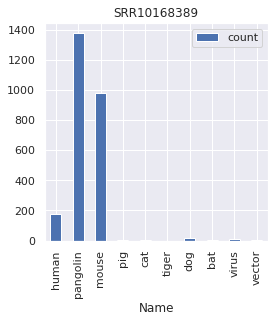

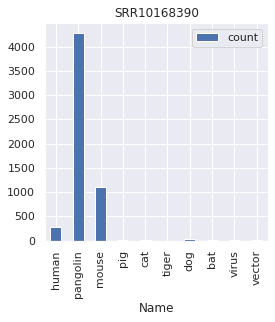

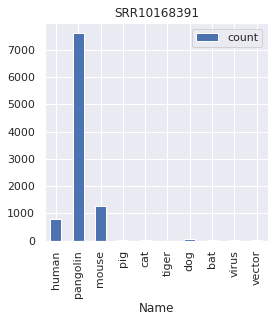

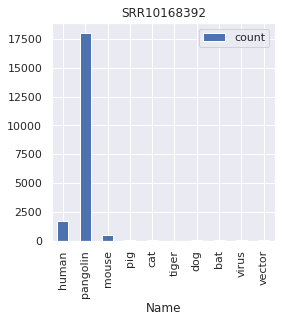

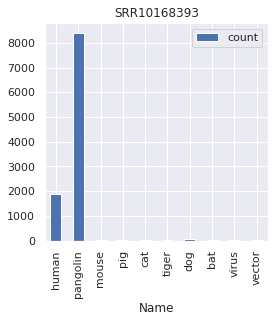

In [52]:
for sra in sra_list:
    try:
        df=get_descr(sra)
        df.to_csv(BASE_PATH+sra+'/magic_blast/'+f'{sra}_{dbname}_{kmer}_magicBLAST_species_df.csv')
        plot_df(df, sra)
    except FileNotFoundError:
        pass

In [136]:
frames=[]
for i,sra in enumerate(sra_list):
    df = pd.read_csv(BASE_PATH+sra+'/magic_blast/'+f'{sra}_{dbname}_{kmer}_magicBLAST_species_df.csv')
    x = df.Name.astype('category')
    df['species_uid'] =x.cat.codes
    df['SRA_val'] =df.SRA.str.strip('SRR')
    df['SRA_val'] = pd.to_numeric(df['SRA_val'])
    frames.append(df)
    
df_sra = pd.concat(frames)

In [137]:
df_sra.drop(columns=['Unnamed: 0'],inplace=True)

In [138]:
df_sra.head()

,SRA,Name,count,fraction_matched,species_uid,SRA_val
0,SRR10168373,human,240,0.055198,3,10168373
1,SRR10168373,pangolin,1380,0.317387,5,10168373
2,SRR10168373,mouse,6,0.001380,4,10168373
3,SRR10168373,pig,3,0.000690,6,10168373
4,SRR10168373,cat,7,0.001610,1,10168373


In [92]:
df_sra.Name.unique()

array(['human', 'pangolin', 'mouse', 'pig', 'cat', 'tiger', 'dog', 'bat',
       'virus', 'vector'], dtype=object)

### All nt database matches

In [157]:
total_dict={}
asc_desc={}
for sra in sra_list:
    accessions, descriptions, counts, total=get_asc_descr_count(sra)
    for asc,desc,cnt in zip(accessions,descriptions, counts):
        if asc in total_dict:
            total_dict[asc]+=int(cnt)
        else:
            total_dict[asc]=int(cnt)
        if asc not in asc_desc:
            asc_desc[asc]=desc

In [158]:
assert len(total_dict)==len(asc_desc)

In [159]:
len(asc_desc)

74327

Print out the 100 most common nt database classification for all contigs in the project

In [164]:
def print_top_n_sp(total_dict, max_num):
    listofTuples = sorted(total_dict.items() , reverse=True, key=lambda x: x[1])
    for i, elem in enumerate(listofTuples):
        if i<max_num:
            print(asc_desc[elem[0]], ": " , elem[1] )
        else:
            break
    

In [165]:
print_top_n_sp(total_dict, max_num=100)

Pseudolabrys sp. FHR47 chromosome, complete genome :  858
Eukaryotic synthetic construct chromosome 16 :  841
Homo sapiens DNA, chromosome 16, nearly complete genome :  810
Lutra lutra genome assembly, chromosome: 16 :  656
Eukaryotic synthetic construct chromosome 17 :  554
Staphylococcus aureus strain WH9628 chromosome :  542
Homo sapiens DNA, chromosome 17, nearly complete genome :  527
Sus scrofa 18S ribosomal RNA gene, complete sequence :  516
Beta vulgaris subsp. vulgaris cultivar KWS2320 chloroplast, complete genome :  507
Homo sapiens clone LA14_101B3 sequence :  506
Homo sapiens clone N29M24 sequence :  494
Mouse DNA sequence from clone RP23-81C12 on chromosome 17, complete sequence :  493
Homo sapiens clone LA13_165F6 sequence :  486
Homo sapiens clone LA15_25H3 sequence :  485
Ovis canadensis canadensis isolate 43U chromosome 24 sequence :  482
Mus musculus clone contig 1 chromocenter region genomic sequence :  480
Human DNA sequence from clone bP-2171C21 on chromosome 21, c

### Human

In [104]:
df=df_sra[df_sra['Name'].str.contains('human')]

count                  AxesSubplot(0.125,0.71587;0.168478x0.16413)
fraction_matched    AxesSubplot(0.327174,0.71587;0.168478x0.16413)
dtype: object

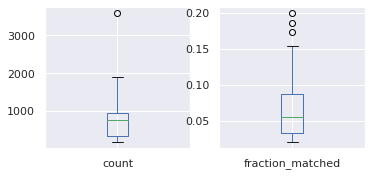

In [105]:
df.drop(columns=['Name'],inplace=True)
sns.set(rc={"figure.figsize":(6, 6)})
df_box=df[['count', 'fraction_matched']]
df_box.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, figsize=(12,12))

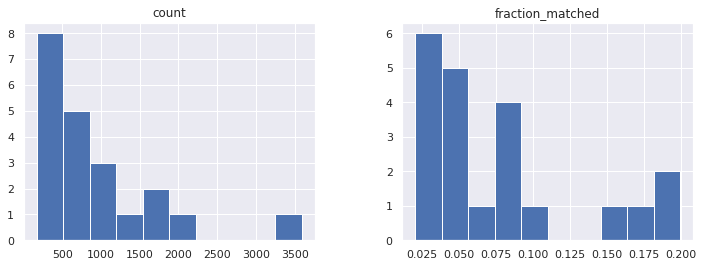

In [106]:
df_box.hist(figsize=(12,4))
plt.show()

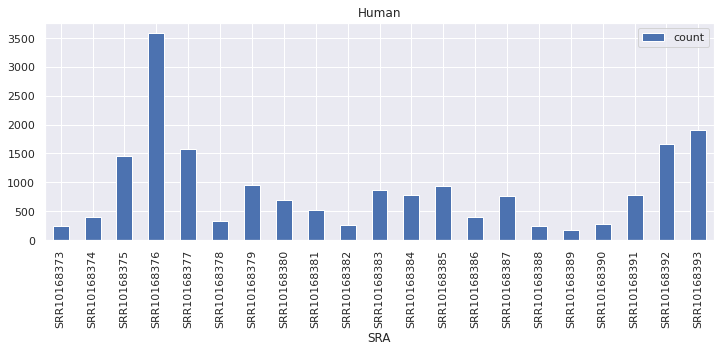

In [109]:
ax=df.plot(x='SRA', y='count', kind='bar',figsize=(12,4))
ax.set_title('Human', fontsize=12)
plt.show()

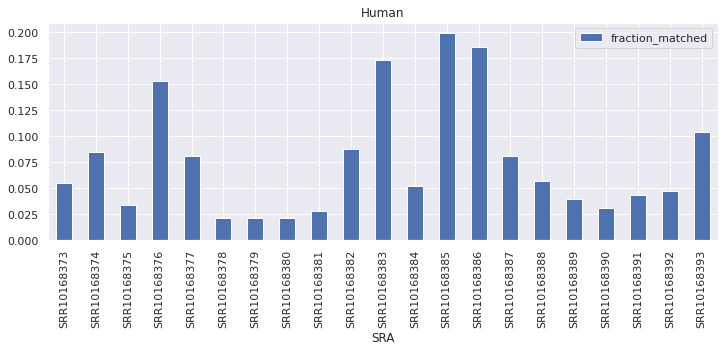

In [110]:
ax=df.plot(x='SRA', y='fraction_matched', kind='bar',figsize=(12,4))
ax.set_title('Human', fontsize=12)
plt.show()

### Pangolin

In [112]:
s_name='pangolin'

In [113]:
df=df_sra[df_sra['Name'].str.contains(s_name)]

count                  AxesSubplot(0.125,0.71587;0.168478x0.16413)
fraction_matched    AxesSubplot(0.327174,0.71587;0.168478x0.16413)
dtype: object

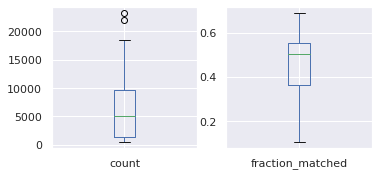

In [114]:
df.drop(columns=['Name'],inplace=True)
sns.set(rc={"figure.figsize":(6, 6)})
df_box=df[['count', 'fraction_matched']]
df_box.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, figsize=(12,12))

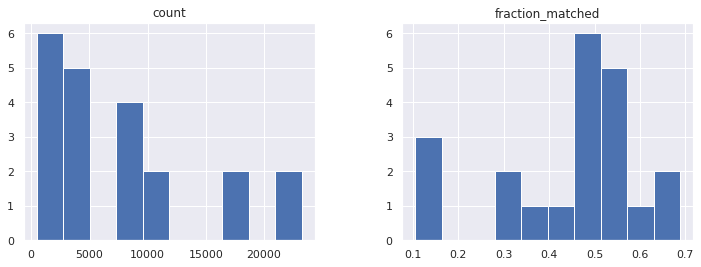

In [115]:
df_box.hist(figsize=(12,4))
plt.show()

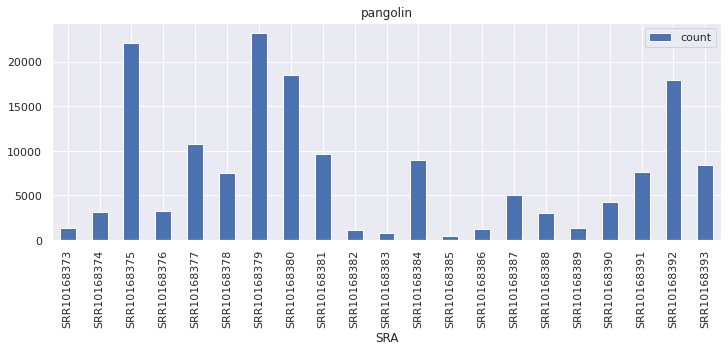

In [117]:
ax=df.plot(x='SRA', y='count', kind='bar',figsize=(12,4))
ax.set_title(s_name, fontsize=12)
plt.show()

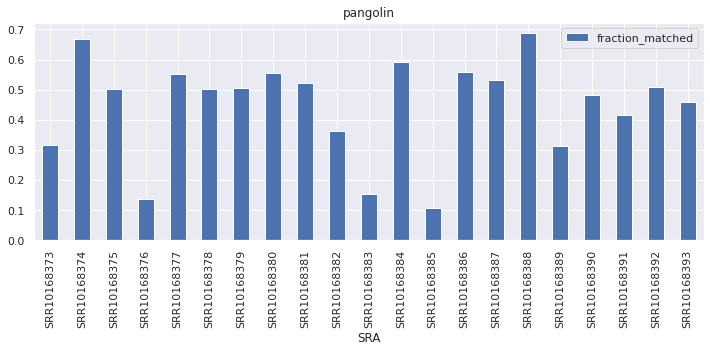

In [118]:
ax=df.plot(x='SRA', y='fraction_matched', kind='bar',figsize=(12,4))
ax.set_title(s_name, fontsize=12)
plt.show()

### Mouse

In [119]:
s_name='mouse'

In [120]:
df=df_sra[df_sra['Name'].str.contains(s_name)]

count                  AxesSubplot(0.125,0.71587;0.168478x0.16413)
fraction_matched    AxesSubplot(0.327174,0.71587;0.168478x0.16413)
dtype: object

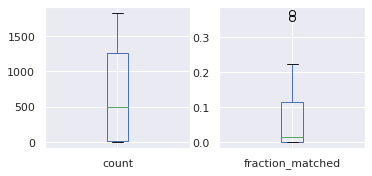

In [121]:
df.drop(columns=['Name'],inplace=True)
sns.set(rc={"figure.figsize":(6, 6)})
df_box=df[['count', 'fraction_matched']]
df_box.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, figsize=(12,12))

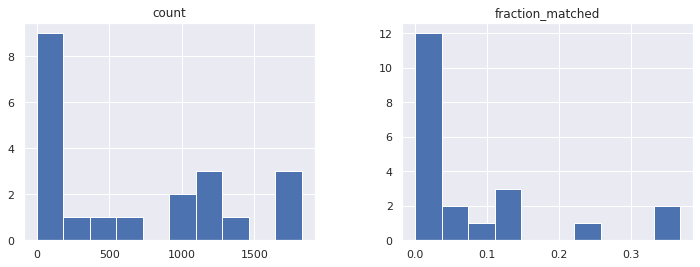

In [122]:
df_box.hist(figsize=(12,4))
plt.show()

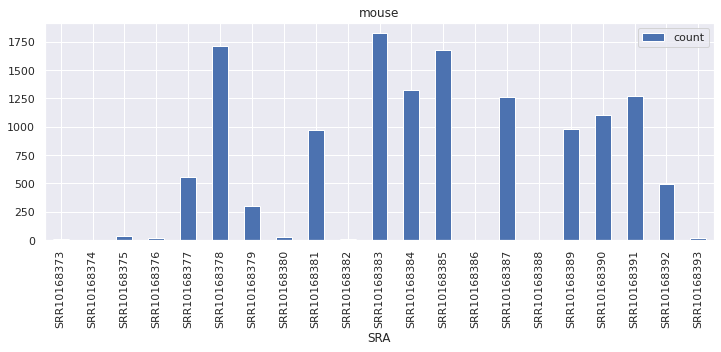

In [123]:
ax=df.plot(x='SRA', y='count', kind='bar',figsize=(12,4))
ax.set_title(s_name, fontsize=12)
plt.show()

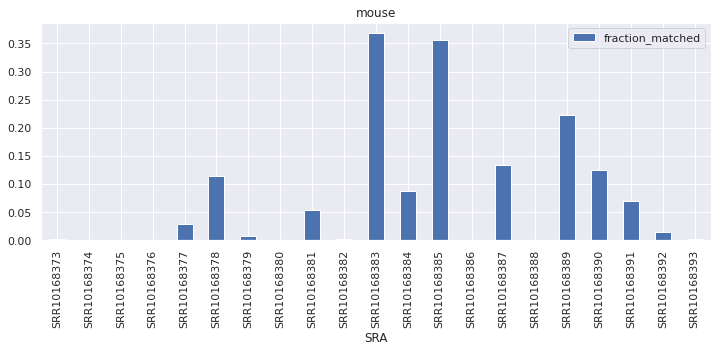

In [124]:
ax=df.plot(x='SRA', y='fraction_matched', kind='bar',figsize=(12,4))
ax.set_title(s_name, fontsize=12)
plt.show()

### virus

In [125]:
s_name='virus'

In [126]:
df=df_sra[df_sra['Name'].str.contains(s_name)]

count                  AxesSubplot(0.125,0.71587;0.168478x0.16413)
fraction_matched    AxesSubplot(0.327174,0.71587;0.168478x0.16413)
dtype: object

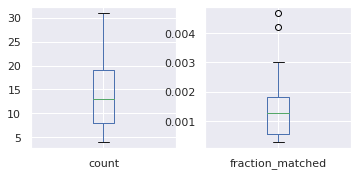

In [127]:
df.drop(columns=['Name'],inplace=True)
sns.set(rc={"figure.figsize":(6, 6)})
df_box=df[['count', 'fraction_matched']]
df_box.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, figsize=(12,12))

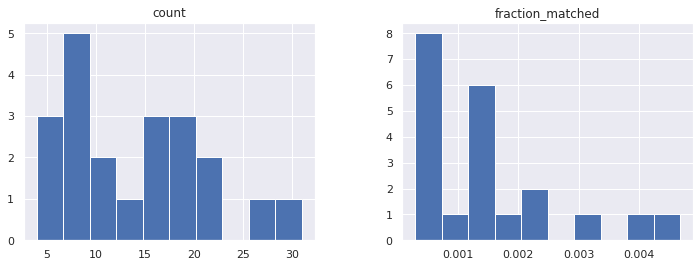

In [128]:
df_box.hist(figsize=(12,4))
plt.show()

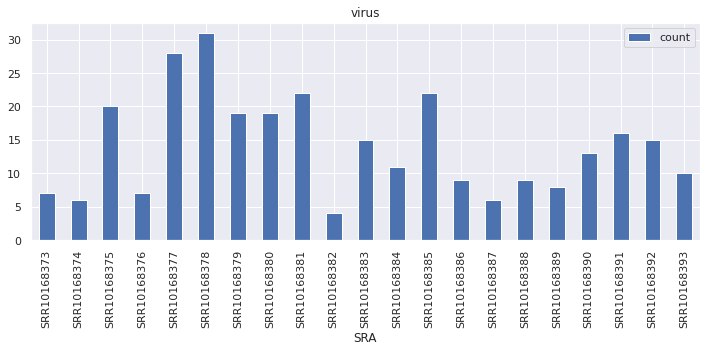

In [129]:
ax=df.plot(x='SRA', y='count', kind='bar',figsize=(12,4))
ax.set_title(s_name, fontsize=12)
plt.show()

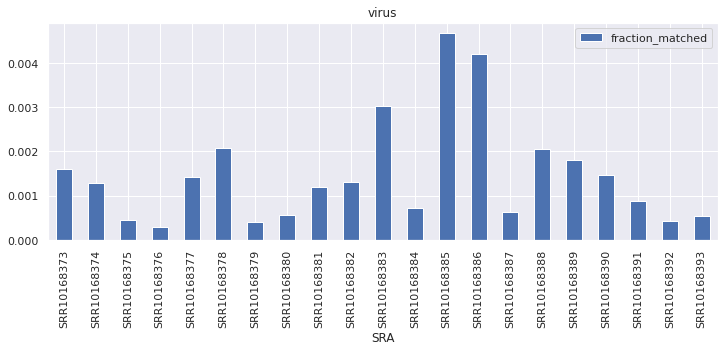

In [130]:
ax=df.plot(x='SRA', y='fraction_matched', kind='bar',figsize=(12,4))
ax.set_title(s_name, fontsize=12)
plt.show()

### Top nt database contigs matches per SRA

In [167]:
def get_sra_dict(sra):
    total_dict={}
    asc_desc={}
    accessions, descriptions, counts, total=get_asc_descr_count(sra)
    for asc,desc,cnt in zip(accessions,descriptions, counts):
        if asc in total_dict:
            total_dict[asc]+=int(cnt)
        else:
            total_dict[asc]=int(cnt)
        if asc not in asc_desc:
            asc_desc[asc]=desc
    return total_dict, asc_desc

In [171]:
for sra in sra_list:
    print(f'{sra}, number of contig matches to nt database: {len(asc_desc)}')
    total_dict, asc_desc= get_sra_dict(sra) 
    print_top_n_sp(total_dict, max_num=50)
    print('\n')

SRR10168373, number of contig matches to nt database: 10877
Manis javanica isolate EP2 mitochondrion, complete genome :  151
Manis javanica isolate T298 mitochondrion, complete genome :  150
Manis javanica isolate MJA633 mitochondrion, complete genome :  140
Manis pentadactyla mitochondrion, complete genome :  101
Manis javanica isolate MP_PG03-UM mitochondrion, complete genome :  100
Sphingomonas paucimobilis strain FDAARGOS_908 chromosome, complete genome :  62
Sphingomonas paucimobilis strain FDAARGOS_881 chromosome, complete genome :  58
Lutra lutra genome assembly, chromosome: 16 :  50
Sphingomonas sp. LK11, complete genome :  49
Staphylococcus aureus strain WH9628 chromosome :  49
Sus scrofa 18S ribosomal RNA gene, complete sequence :  49
Mus musculus clone contig 1 chromocenter region genomic sequence :  48
Sphingomonas paucimobilis DNA, complete genome :  48
Human DNA sequence from clone bP-2171C21 on chromosome 21, complete sequence :  48
Homo sapiens clone N29M24 sequence :  


SRR10168377, number of contig matches to nt database: 7147
Psychrobacter sp. PRwf-1 chromosome, complete genome :  21
Eukaryotic synthetic construct chromosome 17 :  21
Lutra lutra genome assembly, chromosome: 16 :  21
Homo sapiens DNA, chromosome 17, nearly complete genome :  21
Pangolin coronavirus isolate MP789, complete genome :  20
Staphylococcus aureus strain WH9628 chromosome :  18
PREDICTED: Manis javanica AHNAK nucleoprotein (AHNAK), mRNA :  18
Sus scrofa 18S ribosomal RNA gene, complete sequence :  18
Homo sapiens clone LA14_101B3 sequence :  18
Mouse DNA sequence from clone RP23-81C12 on chromosome 17, complete sequence :  18
Ovis canadensis canadensis isolate 43U chromosome 24 sequence :  18
Homo sapiens clone N29M24 sequence :  17
Mus musculus clone contig 1 chromocenter region genomic sequence :  16
Eukaryotic synthetic construct chromosome 15 :  16
Human DNA sequence from clone bP-2171C21 on chromosome 21, complete sequence :  16
Homo sapiens clone LA15_25H3 sequence : 

Eukaryotic synthetic construct chromosome 15 :  8
Eukaryotic synthetic construct chromosome 19 :  8
Beta vulgaris subsp. vulgaris clone SBA036_M09 satellite pEV1 variant sequence :  8
Beta vulgaris subsp. vulgaris mitochondrial DNA, complete genome :  8
Staphylococcus aureus strain WH9628 chromosome :  7
Beta vulgaris subsp. maritima genotype male-fertile B mitochondrion, complete genome :  7
Beta vulgaris subsp. maritima genotype male-fertile A mitochondrion, complete genome :  7
Homo sapiens chromosome X region from filamin (FLN) gene to glucose-6-phosphate dehydrogenase (G6PD) gene, complete cds's :  6
Eukaryotic synthetic construct chromosome 22 :  6
Eukaryotic synthetic construct chromosome 19 :  6
PREDICTED: Globicephala melas collagen alpha-1(II) chain-like (LOC115850433), partial mRNA :  6
Homo sapiens DNA, chromosome 22, nearly complete genome :  6
Acinetobacter bereziniae strain GD0320 chromosome, complete genome :  6
Corynebacterium variabile DSM 44702, complete genome :  6


PREDICTED: Manis pentadactyla 18S ribosomal RNA (LOC118908278), rRNA :  3
PREDICTED: Manis javanica protein tyrosine phosphatase receptor type J (PTPRJ), transcript variant X5, mRNA :  3
PREDICTED: Manis javanica myosin heavy chain 9 (MYH9), transcript variant X1, mRNA :  3


SRR10168389, number of contig matches to nt database: 3512
Clostridium baratii strain CDC51267 chromosome, complete genome :  57
Clostridium baratii str. Sullivan, complete genome :  51
Lutra lutra genome assembly, chromosome: 16 :  33
Staphylococcus aureus strain WH9628 chromosome :  29
Sus scrofa 18S ribosomal RNA gene, complete sequence :  27
Homo sapiens clone N29M24 sequence :  26
Homo sapiens clone LA14_101B3 sequence :  26
Mus musculus clone contig 1 chromocenter region genomic sequence :  25
Mouse DNA sequence from clone RP23-81C12 on chromosome 17, complete sequence :  25
Homo sapiens clone LA15_25H3 sequence :  24
Homo sapiens clone LA13_165F6 sequence :  24
Ovis canadensis canadensis isolate 43U chromos

Lutra lutra genome assembly, chromosome: 16 :  107
Staphylococcus aureus strain WH9628 chromosome :  88
Sus scrofa 18S ribosomal RNA gene, complete sequence :  87
Mouse DNA sequence from clone RP23-81C12 on chromosome 17, complete sequence :  82
Homo sapiens clone LA14_101B3 sequence :  79
Homo sapiens clone N29M24 sequence :  77
Homo sapiens clone LA15_25H3 sequence :  77
Mus musculus clone contig 1 chromocenter region genomic sequence :  76
Homo sapiens clone LA13_165F6 sequence :  75
Human DNA sequence from clone bP-2171C21 on chromosome 21, complete sequence :  74
Ovis canadensis canadensis isolate 43U chromosome 24 sequence :  74
PREDICTED: Globicephala melas collagen alpha-1(II) chain-like (LOC115850433), partial mRNA :  58
Homo sapiens DNA, chromosome 17, nearly complete genome :  23
Eukaryotic synthetic construct chromosome 17 :  22
PREDICTED: Manis pentadactyla 28S ribosomal RNA (LOC118908279), rRNA :  22
PREDICTED: Manis javanica AHNAK nucleoprotein (AHNAK), mRNA :  22
Eukary